### Diffusion constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from dataset import mnist
from util import (
    get_torch_size_string,
    plot_1xN_torch_img_tensor,
    plot_1xN_torch_traj_tensor,
    hbm_sampler
)
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    timestep_embedding,
    forward_sample
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


`DDPM` Equations \
Forward diffusion process:
$$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$$
$$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

Reverse diffusion process posterior:
$$ 
q(x_{t-1}|x_t,x_0) = \mathcal{N}
\left(
x_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

### Get `DDPM` constants

[ 0] key:[schedule_name]
[ 1] key:[T]
[ 2] key:[timesteps]
[ 3] key:[betas]
[ 4] key:[alphas]
[ 5] key:[alphas_bar]
[ 6] key:[alphas_bar_prev]
[ 7] key:[sqrt_recip_alphas]
[ 8] key:[sqrt_alphas_bar]
[ 9] key:[sqrt_one_minus_alphas_bar]
[10] key:[posterior_variance]


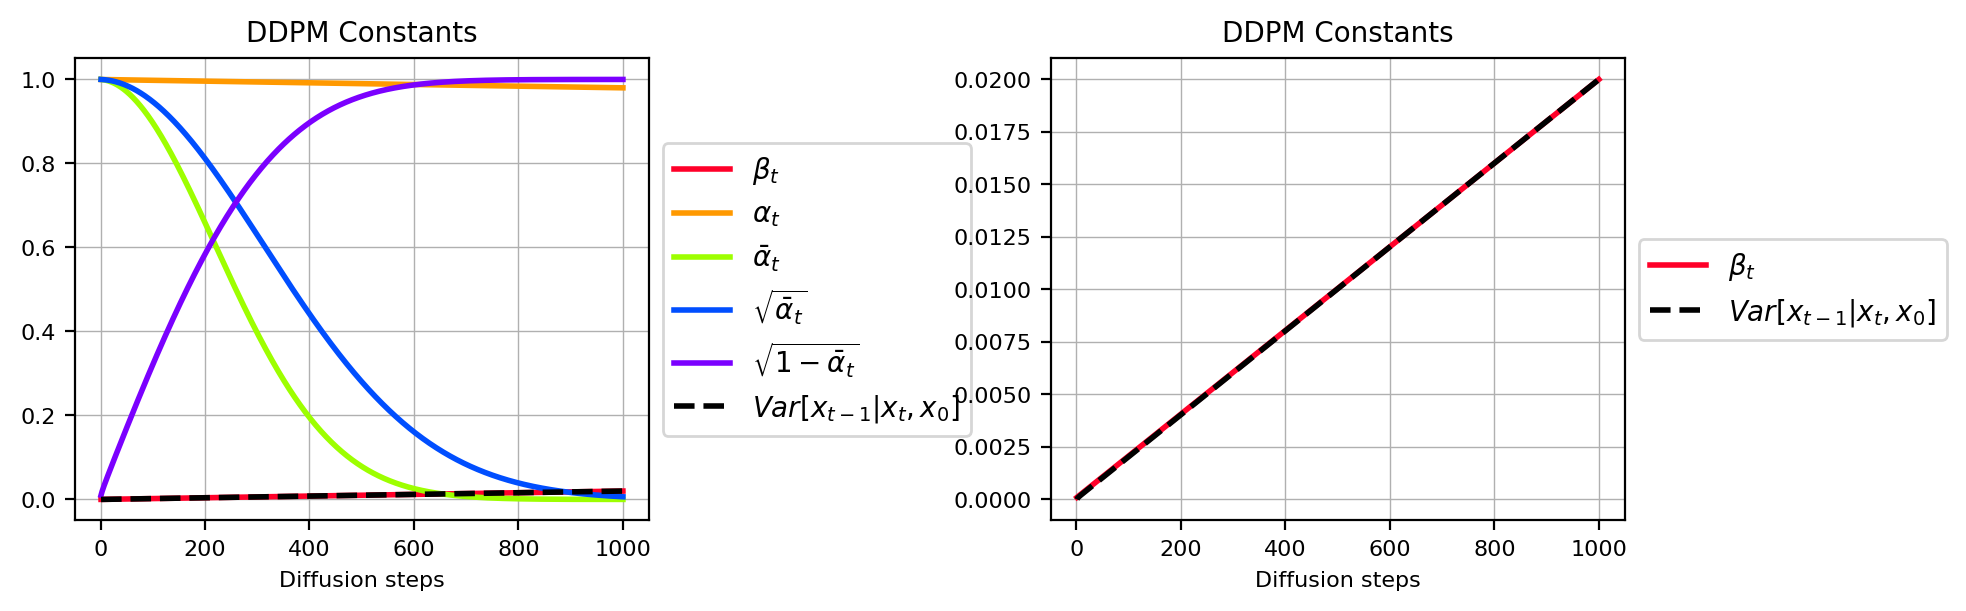

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'linear', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
for k_idx,key in enumerate(dc.keys()):
    print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

[ 0] key:[schedule_name]
[ 1] key:[T]
[ 2] key:[timesteps]
[ 3] key:[betas]
[ 4] key:[alphas]
[ 5] key:[alphas_bar]
[ 6] key:[alphas_bar_prev]
[ 7] key:[sqrt_recip_alphas]
[ 8] key:[sqrt_alphas_bar]
[ 9] key:[sqrt_one_minus_alphas_bar]
[10] key:[posterior_variance]


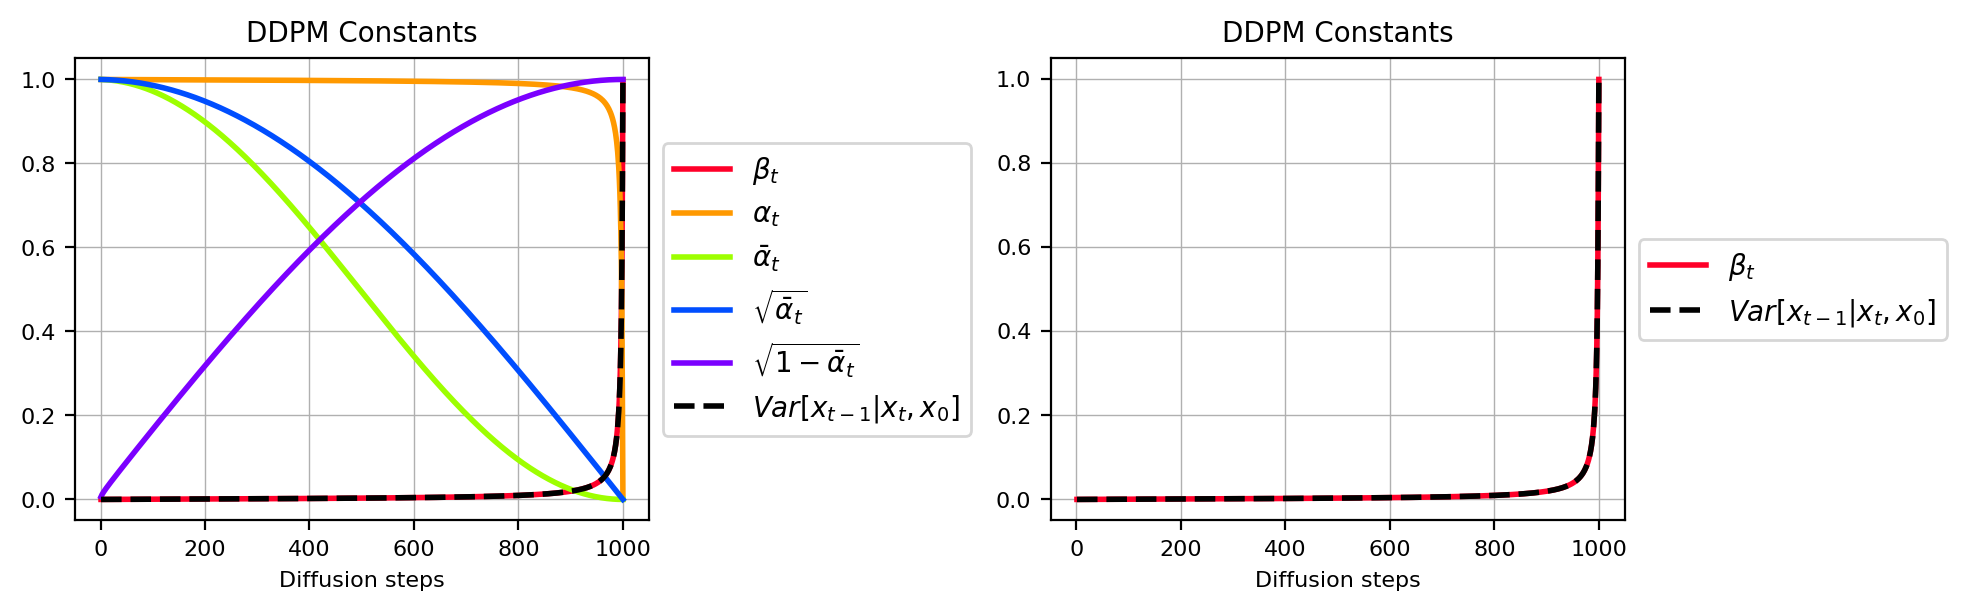

In [3]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
for k_idx,key in enumerate(dc.keys()):
    print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

### Time embedding

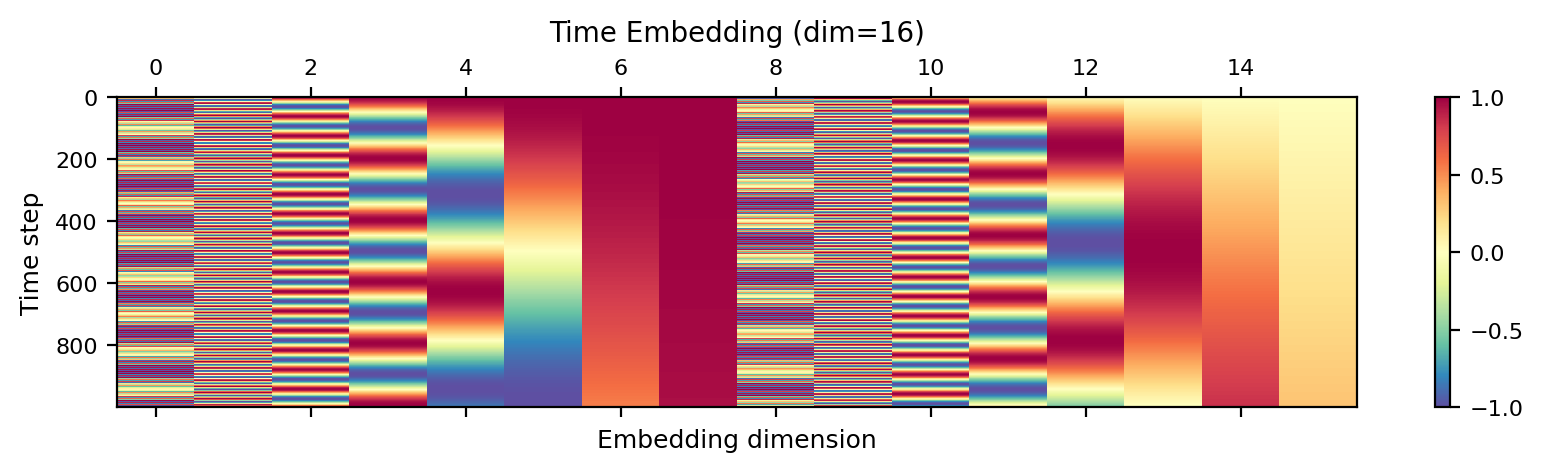

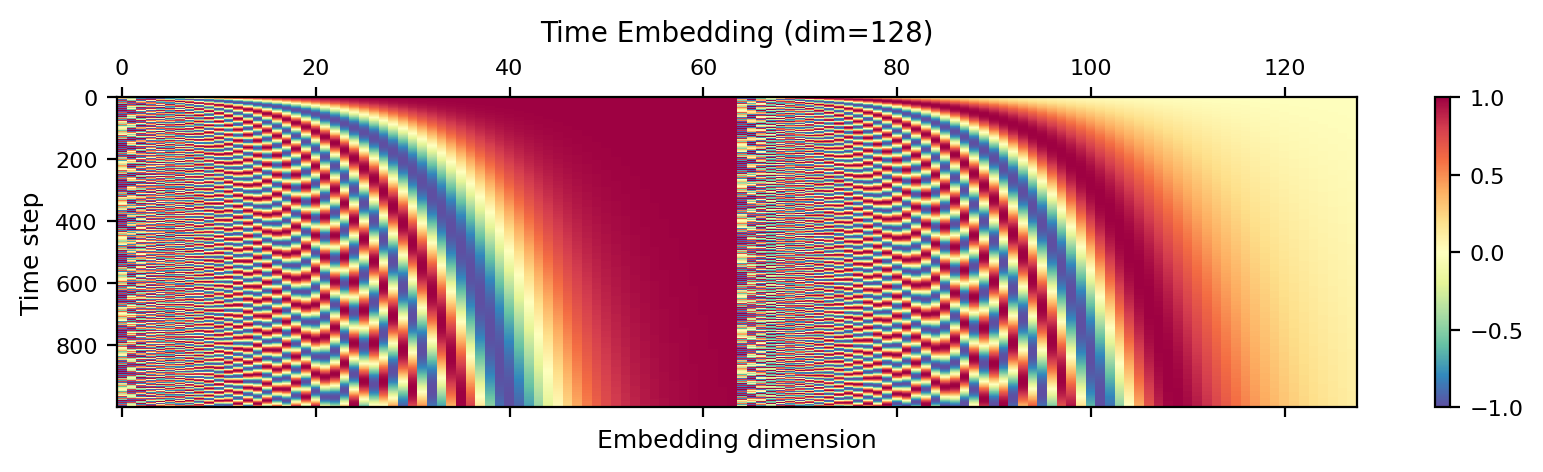

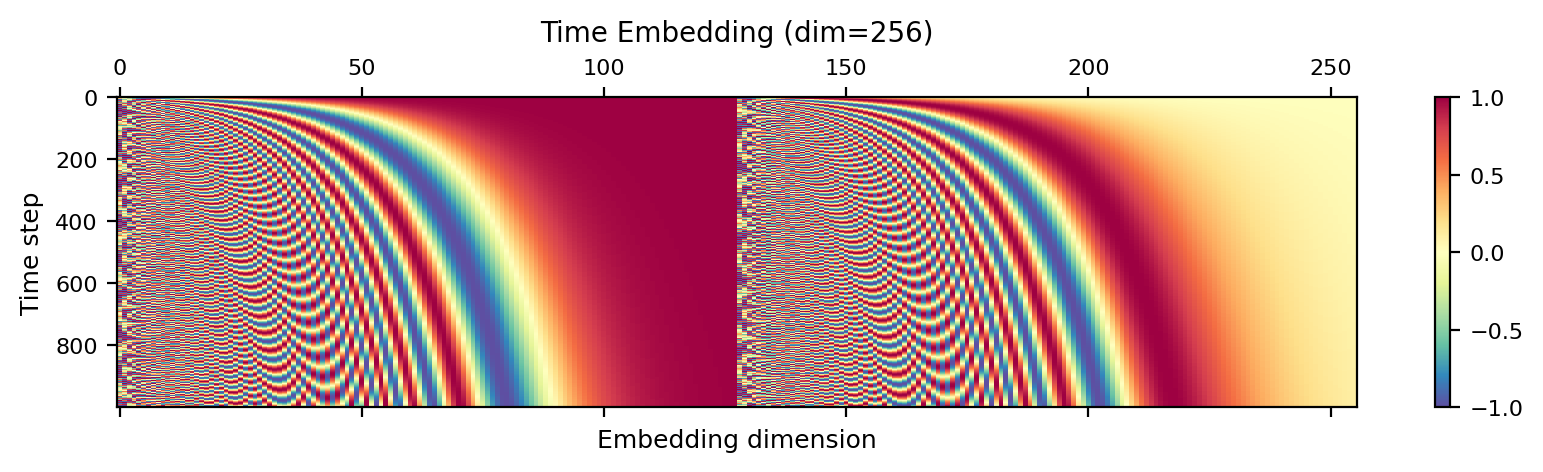

In [4]:
for emb_dim in [16,128,256]:
    time_embs = timestep_embedding(
        timesteps  = th.from_numpy(dc['timesteps']), # [L]
        dim        = emb_dim,
        max_period = 10000,
    ) # [L x D]
    # Plot
    plt.figure(figsize=(10,2))
    plt.matshow(time_embs,fignum=1,aspect='auto',cmap=plt.cm.Spectral_r)
    plt.xlabel('Embedding dimension',fontsize=9)
    plt.ylabel('Time step',fontsize=9)
    plt.colorbar()
    plt.title('Time Embedding (dim=%d)'%(emb_dim),fontsize=10) 
    plt.show()

### Forward sampling of images

In [5]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready. train_data:[%s]"%(get_torch_size_string(train_data)))

MNIST ready. train_data:[60000x28x28]


Forward diffusion process:
$$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$$
$$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

In [6]:
device = 'mps'
print ("device:[%s]"%(device))

device:[mps]


In [7]:
batch_size = 10
x0_batch = th.tile(
    input = train_data[0,:,:][None,None,:,:]/255.,
    dims  = (batch_size,1,1,1)).to(device) # [B x C x W x H]
t_batch = th.linspace(0,dc['T']-1,batch_size).to(th.int64).to(device) # [B]
# Forward diffusion sampling of [B x C x W x H]
xt_batch,noise = forward_sample(x0_batch,t_batch,dc)
print ("x0_batch:[%s] t_batch:[%s] => xt_batch:[%s] noise:[%s]"%(
    get_torch_size_string(x0_batch),get_torch_size_string(t_batch),
    get_torch_size_string(xt_batch),get_torch_size_string(noise)))

x0_batch:[10x1x28x28] t_batch:[10] => xt_batch:[10x1x28x28] noise:[10x1x28x28]


Plot forward samples

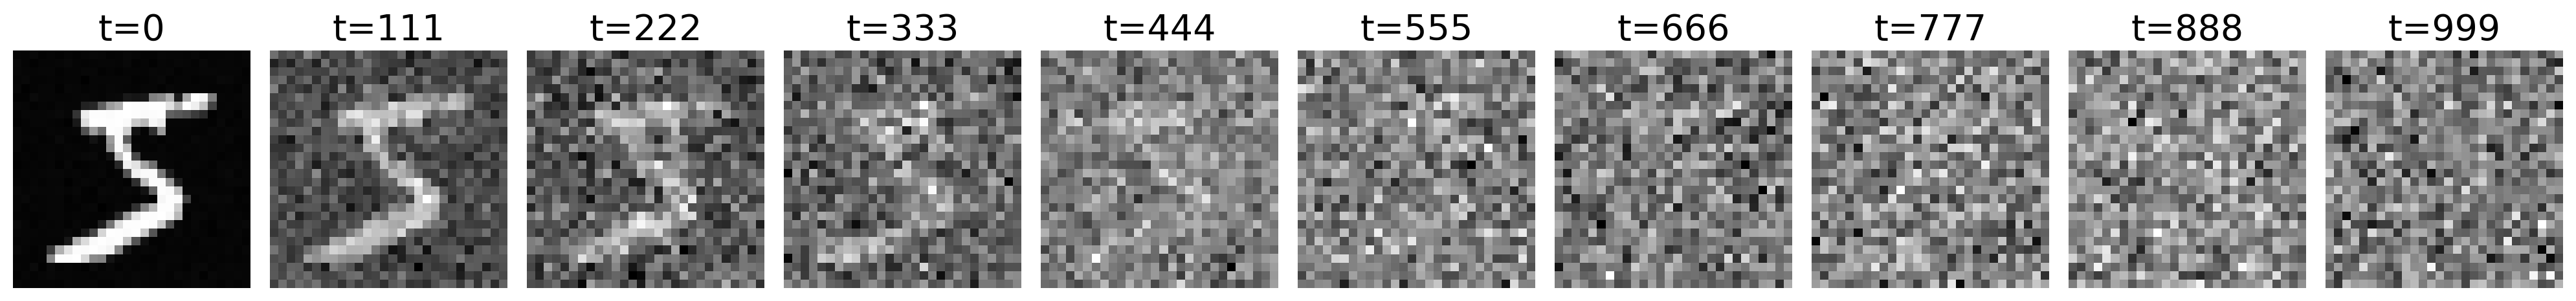

In [8]:
title_str_list = ['t=%d'%(x.cpu().item()) for x in t_batch]
plot_1xN_torch_img_tensor(xt_batch,title_str_list)

### Forward sampling of trajectories

In [9]:
times = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)) # [L x 1]
traj = th.from_numpy(
    hbm_sampler(
        times    = times,
        hyp_gain = 2.0,
        hyp_len  = 0.2,
        meas_std = 1e-8,
        n_traj   = 10
    )
).to(th.float32).to(device) # [10 x L]
print ("1D trajectories ready. traj:[%s]"%(get_torch_size_string(traj)))

1D trajectories ready. traj:[10x100]


In [10]:
batch_size = 10
x0_batch = th.tile(
    input = traj[0,:][None,None,:],
    dims  = (batch_size,1,1)).to(device) # [B x C x L]
t_batch = th.linspace(0,dc['T']-1,batch_size).to(th.int64).to(device) # [B]
# Forward diffusion sampling of [B x C x L]
xt_batch,noise = forward_sample(x0_batch,t_batch,dc)
print ("x0_batch:[%s] t_batch:[%s] => xt_batch:[%s] noise:[%s]"%(
    get_torch_size_string(x0_batch),get_torch_size_string(t_batch),
    get_torch_size_string(xt_batch),get_torch_size_string(noise)))

x0_batch:[10x1x100] t_batch:[10] => xt_batch:[10x1x100] noise:[10x1x100]


Plot forward samples

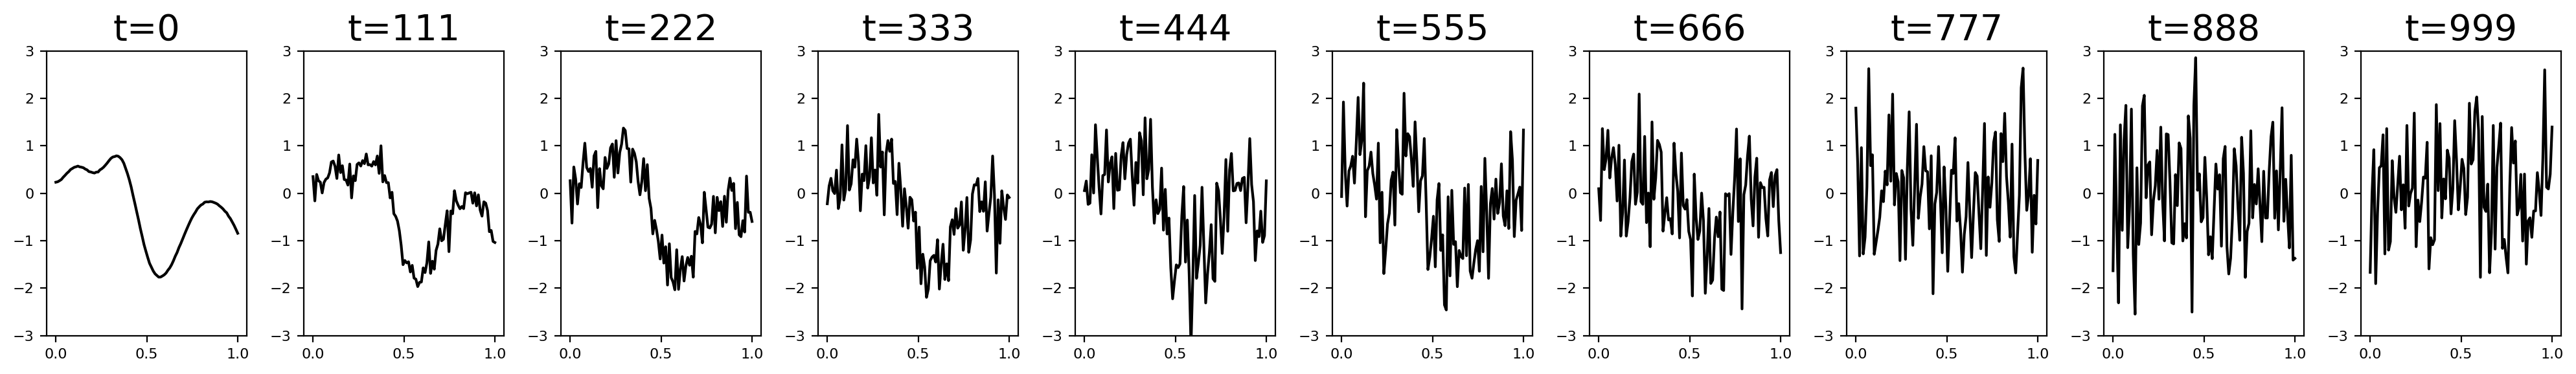

In [11]:
title_str_list = ['t=%d'%(x.cpu().item()) for x in t_batch]
plot_1xN_torch_traj_tensor(times,xt_batch,title_str_list,ylim=[-3,+3])

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$ \
2: $t \sim \text{Uniform}(\{ 1, \ldots, T \})$ \
3: $ \boldsymbol{\color{red} \epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
4: Take gradient descent step on 

$$
\tilde{\mathbf{x}}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon}
$$
$$ 
    \nabla 
    \| \boldsymbol{\color{red} \epsilon} - 
        \boldsymbol{\epsilon}_{\theta}(\tilde{\mathbf{x}}_t,t) 
    \|^2
$$

### `Algorithm 2` Sampling
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_t,t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$